In [1]:
import pandas as pd
import os
from glob import glob

# GPU config

In [2]:
import torch
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda:1")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
We will use the GPU: NVIDIA A100-PCIE-40GB


# Load Data

In [4]:
path = '../coded_speeches/'
files = sorted(glob(path+'*.xlsx'))
print(files)


['../coded_speeches/108_ak.xlsx', '../coded_speeches/108_ln.xlsx', '../coded_speeches/10_ak.xlsx', '../coded_speeches/10_ln.xlsx', '../coded_speeches/112_ln.xlsx', '../coded_speeches/114_ln.xlsx', '../coded_speeches/137_ak.xlsx', '../coded_speeches/137_ln.xlsx', '../coded_speeches/138_ak.xlsx', '../coded_speeches/138_ln.xlsx', '../coded_speeches/139_ak.xlsx', '../coded_speeches/139_ln.xlsx', '../coded_speeches/140_ak.xlsx', '../coded_speeches/140_ln.xlsx', '../coded_speeches/142_ak.xlsx', '../coded_speeches/142_ln.xlsx', '../coded_speeches/143_ak.xlsx', '../coded_speeches/143_ln.xlsx', '../coded_speeches/144_ak.xlsx', '../coded_speeches/144_ln.xlsx', '../coded_speeches/145_ak.xlsx', '../coded_speeches/145_ln.xlsx', '../coded_speeches/14_ak.xlsx', '../coded_speeches/14_ln.xlsx', '../coded_speeches/150_ak.xlsx', '../coded_speeches/150_ln.xlsx', '../coded_speeches/152_ak.xlsx', '../coded_speeches/152_ln.xlsx', '../coded_speeches/153_ak.xlsx', '../coded_speeches/153_ln.xlsx', '../coded_spe

In [5]:
cols = pd.read_excel(files[1], skiprows=7).drop(columns=['Unnamed: 0']).columns
print(len(cols))
data = pd.DataFrame(columns=[*cols])

temp_values = []
for file in files:
    temp = pd.read_excel(file, skiprows=7).drop(columns=['Unnamed: 0'])
    temp_values.append(temp)
    
new_cols = dict(zip(cols, ["sentence","Metaphor","Simile","Rhetorical_questions", "Stories_anecdotes", "Contrasts", "Lists", "Repetition", "Moral_conviction", "Sentiment_of_the_collective", "Setting_high_expectations", "Confidence_in_goals"]))
                    # ['sentence', 'metaphor', 'simile', 'question', 'reference', 'figure_of_speech', 'lists', 'repetition', 'personal_statement', 'value_statement', 'explicit_goal', 'believe_statement']))


data = pd.concat(temp_values).rename(columns = new_cols).fillna(0)
data

12


,sentence,Metaphor,Simile,Rhetorical_questions,Stories_anecdotes,Contrasts,Lists,Repetition,Moral_conviction,Sentiment_of_the_collective,Setting_high_expectations,Confidence_in_goals
0,"All right, good afternoon everybody, and welco...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Im here with Paul Mounds and Roland Cook Ill i...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Just to give you our briefing.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"First of all, in terms of where we are in the ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Um, another 1200 people tested positive at a 3...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
284,I firmly believe our mission is the same: a sa...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
285,I look forward to working with you all in the ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
286,Thank you all for your work as public servants.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
287,God bless you.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
len(data[data.Metaphor==1])/len(data)

0.025425026803492113

In [7]:
nan_count = data.isna().sum()
nan_count

sentence                       0
Metaphor                       0
Simile                         0
Rhetorical_questions           0
Stories_anecdotes              0
Contrasts                      0
Lists                          0
Repetition                     0
Moral_conviction               0
Sentiment_of_the_collective    0
Setting_high_expectations      0
Confidence_in_goals            0
dtype: int64

# BERT Fine-tuning

In [8]:
#split the dataset to train and test sets with 20-80 proportion
from sklearn.model_selection import train_test_split

#y = data['metaphor'].values
y = data.drop(columns=['sentence']).values #get the labels
train, test = train_test_split(data, test_size=0.2, random_state=1337)

In [9]:
# Get the lists of sentences and their labels.
sentences = train.sentence.values
colname = "All"
labels =  train.drop(columns=['sentence']).values

In [10]:
sentences.shape

(10446,)

In [11]:
labels.shape

(10446, 11)

In [12]:
from transformers import BertTokenizer
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

2023-03-15 08:59:56.407085: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 08:59:56.571870: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-15 08:59:57.150962: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-15 08:59:57.151034: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

Loading BERT tokenizer...


In [13]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)
# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  Funding the trust is no small investment, but I believe that its one we need to make.
Token IDs: [101, 4804, 1996, 3404, 2003, 2053, 2235, 5211, 1010, 2021, 1045, 2903, 2008, 2049, 2028, 2057, 2342, 2000, 2191, 1012, 102]


Below are different values we can try for padding the data depnding on the dataset

In [14]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  126


In [15]:
# get the distribution of sentence lengths
sentences_len = [len(sen) for sen in sentences]
sentences_len[:5]

[85, 58, 85, 106, 22]

In [16]:
# 90th percentile of data with lengths
import numpy as np
p = np.percentile(sentences_len, 90)
p

182.0

In [17]:
#mean of sentence lengths
np.mean(sentences_len)

96.93059544323187

In [18]:
# We'll use the `pad_sequences` utility function to do this.
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Set the maximum sequence length.
# 149 is the mean of sequence lengths
MAX_LEN = max([len(sen) for sen in input_ids])
print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)
print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))
# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

labels = torch.tensor(labels,dtype=torch.long)
print('\Done.')


Padding/truncating all sentences to 126 values...

Padding token: "[PAD]", ID: 0
\Done.


In [19]:
# Create attention masks
attention_masks = []
# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

In [20]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split
# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)


In [21]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

/tmp/ipykernel_2519919/3629088030.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels)
/tmp/ipykernel_2519919/3629088030.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_labels = torch.tensor(validation_labels)


In [22]:
train_labels.shape

torch.Size([9401, 11])

In [23]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
batch_size = 32#*labels.shape[1] #32 # 32*11
# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [24]:

from transformers import BertForSequenceClassification, AdamW, BertConfig
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = labels.shape[1], # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    problem_type="multi_label_classification",
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
#problem_type="multi_label_classification"
)
# Tell pytorch to run this model on the GPU.
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [25]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())
print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== First Transformer ====\n')
for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== Output Layer ====\n')
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [26]:
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
from transformers import get_linear_schedule_with_warmup
# Number of training epochs (authors recommend between 2 and 4)
epochs = 20
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs
# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

/home/datasciencefhswf/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [27]:
import numpy as np
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [28]:
import time
import datetime
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [29]:
print(torch.cuda.memory_summary(device=None, abbreviated=True))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| GPU reserved memory   |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------

In [30]:
import random
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128
# Set the seed value all over the place to make this reproducible.
torch.cuda.empty_cache()
seed_val = 421337
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
# Store the average loss after each epoch so we can plot them.
loss_values = []
# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    # Reset the total loss for this epoch.
    total_loss = 0
    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()
    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        
        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels.to(torch.float))
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()
        # Update the learning rate.
        scheduler.step()
    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")
    t0 = time.time()
    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()
    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy
        # Track the number of batches
        nb_eval_steps += 1
    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
print("")
print("Training complete!")


======== Epoch 1 / 20 ========
Training...
  Batch    40  of    294.    Elapsed: 0:00:07.
  Batch    80  of    294.    Elapsed: 0:00:14.
  Batch   120  of    294.    Elapsed: 0:00:21.
  Batch   160  of    294.    Elapsed: 0:00:27.
  Batch   200  of    294.    Elapsed: 0:00:34.
  Batch   240  of    294.    Elapsed: 0:00:41.
  Batch   280  of    294.    Elapsed: 0:00:47.

  Average training loss: 0.23
  Training epoch took: 0:00:50

Running Validation...


/tmp/ipykernel_2519919/2869592228.py:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return np.sum(pred_flat == labels_flat) / len(labels_flat)


  Accuracy: 0.00
  Validation took: 0:00:02

======== Epoch 2 / 20 ========
Training...
  Batch    40  of    294.    Elapsed: 0:00:07.
  Batch    80  of    294.    Elapsed: 0:00:13.
  Batch   120  of    294.    Elapsed: 0:00:20.
  Batch   160  of    294.    Elapsed: 0:00:27.
  Batch   200  of    294.    Elapsed: 0:00:34.
  Batch   240  of    294.    Elapsed: 0:00:40.
  Batch   280  of    294.    Elapsed: 0:00:47.

  Average training loss: 0.17
  Training epoch took: 0:00:50

Running Validation...
  Accuracy: 0.00
  Validation took: 0:00:02

======== Epoch 3 / 20 ========
Training...
  Batch    40  of    294.    Elapsed: 0:00:07.
  Batch    80  of    294.    Elapsed: 0:00:14.
  Batch   120  of    294.    Elapsed: 0:00:20.
  Batch   160  of    294.    Elapsed: 0:00:27.
  Batch   200  of    294.    Elapsed: 0:00:34.
  Batch   240  of    294.    Elapsed: 0:00:41.
  Batch   280  of    294.    Elapsed: 0:00:47.

  Average training loss: 0.13
  Training epoch took: 0:00:50

Running Validation

  Batch   120  of    294.    Elapsed: 0:00:20.
  Batch   160  of    294.    Elapsed: 0:00:27.
  Batch   200  of    294.    Elapsed: 0:00:34.
  Batch   240  of    294.    Elapsed: 0:00:40.
  Batch   280  of    294.    Elapsed: 0:00:47.

  Average training loss: 0.04
  Training epoch took: 0:00:50

Running Validation...
  Accuracy: 0.00
  Validation took: 0:00:02

======== Epoch 19 / 20 ========
Training...
  Batch    40  of    294.    Elapsed: 0:00:07.
  Batch    80  of    294.    Elapsed: 0:00:13.
  Batch   120  of    294.    Elapsed: 0:00:20.
  Batch   160  of    294.    Elapsed: 0:00:27.
  Batch   200  of    294.    Elapsed: 0:00:34.
  Batch   240  of    294.    Elapsed: 0:00:40.
  Batch   280  of    294.    Elapsed: 0:00:47.

  Average training loss: 0.04
  Training epoch took: 0:00:50

Running Validation...
  Accuracy: 0.00
  Validation took: 0:00:02

======== Epoch 20 / 20 ========
Training...
  Batch    40  of    294.    Elapsed: 0:00:07.
  Batch    80  of    294.    Elapsed: 0:0

In [31]:
torch.save(model.state_dict(), colname+'_4epoch_state_dict.pt')
torch.save(model, colname+'_label_4epoch.pt')

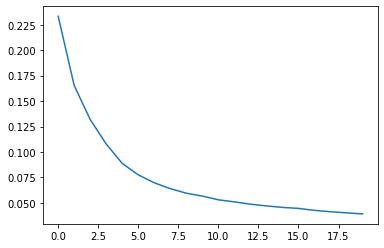

In [32]:
import matplotlib.pyplot as plt
f = pd.DataFrame(loss_values)
f.columns=['Loss']
fig = plt.plot(f.index, f.Loss)
plt.show()

In [36]:
#Test data

import pandas as pd
# Load the dataset into a pandas dataframe.

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(test.shape[0]))
# Create sentence and label lists
sentences = test.sentence.values
labels = test.drop(columns=['sentence']).values
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")
labels = torch.tensor(labels,dtype=torch.long)
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 
# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
# Set the batch size.  
batch_size = 32  
# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 2,612



/tmp/ipykernel_2519919/1675000927.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prediction_labels = torch.tensor(labels)


In [37]:
import tensorflow as tf
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))
# Put model in evaluation mode
model.eval()
# Tracking variables 
predictions , true_labels, prediction_probs = [], [],[] #Atefeh
# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)
  logits = outputs[0]
  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  prediction_probs.append (tf.nn.softmax(logits))

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)
print('DONE.')

Predicting labels for 2,612 test sentences...


2023-03-15 10:12:52.936738: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 10:12:54.379095: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 292 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2023-03-15 10:12:54.380894: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 31365 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0


DONE.


In [38]:
prediction_probs[:1]

[<tf.Tensor: shape=(32, 11), dtype=float32, numpy=
 array([[2.61114601e-05, 4.26402585e-06, 2.74155764e-06, 1.96892797e-05,
         5.08454432e-05, 2.24795687e-04, 3.01743683e-04, 9.99251187e-01,
         7.72644944e-06, 8.44092428e-05, 2.64823921e-05],
        [8.61293375e-02, 2.81677600e-02, 4.83821481e-02, 2.15065375e-01,
         5.15096001e-02, 1.11900419e-01, 7.48271421e-02, 1.28092751e-01,
         6.82540014e-02, 1.24306947e-01, 6.33644983e-02],
        [4.81867173e-05, 2.10281432e-05, 9.45708871e-06, 1.41110126e-04,
         1.65656777e-04, 5.76672173e-05, 1.00713689e-03, 9.97807682e-01,
         3.71178867e-05, 1.26943705e-04, 5.78060048e-04],
        [3.74446176e-02, 1.02180233e-02, 2.28923410e-02, 2.49857292e-01,
         2.33810812e-01, 2.10179225e-01, 3.13802026e-02, 1.50536209e-01,
         1.94865186e-02, 2.09192857e-02, 1.32754911e-02],
        [3.77812685e-05, 2.65003837e-05, 1.83009397e-05, 2.26559132e-05,
         1.01445970e-04, 9.13972472e-05, 3.69915426e-01, 4.8

# Evaluation Metrics

In [39]:
from sklearn.metrics import matthews_corrcoef
matthews_set = []
print(predictions[0].shape)
# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')
# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

(32, 11)
Calculating Matthews Corr. Coef. for each batch...


ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

In [40]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]
# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)
print('MCC: %.3f' % mcc)

ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

In [41]:
# Combine the predictions for each batch into a single list of 0s and 1s.
#By Atefeh here we have prediction_probs list instead of predictions
flat_predictions = [item for sublist in prediction_probs for item in sublist]
#flat_predictions = np.amax(flat_predictions, axis=1).flatten()

flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

In [42]:
from sklearn.metrics import auc
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,confusion_matrix,auc

def roc_curve_plot(fpr,tpr,roc_auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' %roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for tactic: '+colname)
    plt.legend(loc="lower right")
    plt.show()

In [43]:
from sklearn.metrics import confusion_matrix
confusion_matrix(flat_true_labels,flat_predictions)

ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

In [44]:
# visualize the ROC curve
fpr, tpr, _ = roc_curve(flat_true_labels,flat_predictions)
roc_auc = auc(fpr, tpr)
roc_curve_plot(fpr,tpr,roc_auc)

ValueError: multilabel-indicator format is not supported

In [ ]:

fpr, tpr, _ = roc_curve(flat_true_labels,flat_predictions)
roc_auc = auc(fpr, tpr)
roc_curve_plot(fpr,tpr,roc_auc)

In [ ]:
def plot_cm(y_true, y_pred, title):
    ''''
    input y_true-Ground Truth Labels
          y_pred-Predicted Value of Model
          title-What Title to give to the confusion matrix
    
    Draws a Confusion Matrix for better understanding of how the model is working
    
    return None
    
    '''
    
    figsize=(10,10)
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

In [ ]:
plot_cm(flat_true_labels, flat_predictions, colname)

In [ ]:
#new data 149len and 4 epochs
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print('Accuracy: %.3f' % accuracy_score(flat_true_labels, flat_predictions))
print('Precision: %.3f' % precision_score(flat_true_labels, flat_predictions))
print('Recall: %.3f' % recall_score(flat_true_labels, flat_predictions))
print('F1 Score: %.3f' % f1_score(flat_true_labels, flat_predictions))

In [ ]:
# vergleiche oder listen
# stories
# repetitions

In [ ]:
torch.cuda.empty_cache()